% DES431 Project 2: Recommendation System

In [31]:
# Data processing
import pandas as pd
import numpy as np
import scipy.stats
import math

# Visualization
import seaborn as sns

# Similarity
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

# Loading data

In [32]:
ratings_train = pd.read_csv('ratings_train.csv')
ratings_valid = pd.read_csv('ratings_valid.csv')
movies = pd.read_csv('movies.csv')
links = pd.read_csv('links.csv')
tags = pd.read_csv('tags.csv')


In [33]:
# Number of users
print('The ratings dataset has', ratings_train['userId'].nunique(), 'unique users')
# Number of movies
print('The ratings dataset has', ratings_train['movieId'].nunique(), 'unique movies')
# Number of ratings
print('The ratings dataset has', ratings_train['rating'].nunique(), 'unique ratings')
# List of unique ratings
print('The unique ratings are', sorted(ratings_train['rating'].unique()))

The ratings dataset has 610 unique users
The ratings dataset has 9690 unique movies
The ratings dataset has 10 unique ratings
The unique ratings are [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]


# Constructing model and predicting ratings

###Weighted avg approach###

In [34]:
#merge df -> Train set
df_train = pd.merge(ratings_train, movies, on='movieId', how='inner')
df_train = pd.merge(df_train, links, on='movieId', how='inner')
df_train

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
...,...,...,...,...,...,...,...,...
96459,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller,118745,30948.0
96460,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama,66806,90351.0
96461,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller,798722,70193.0
96462,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller,1540011,351211.0


In [35]:
# Test set
df_test = pd.merge(ratings_valid, movies, on='movieId', how='inner')
df_test = pd.merge(df_test, links, on='movieId', how='inner')
df_test

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,4,45,3.0,986935047,To Die For (1995),Comedy|Drama|Thriller,114681,577.0
1,217,45,2.0,955943999,To Die For (1995),Comedy|Drama|Thriller,114681,577.0
2,4,52,3.0,964622786,Mighty Aphrodite (1995),Comedy|Drama|Romance,113819,11448.0
3,57,52,3.0,969753586,Mighty Aphrodite (1995),Comedy|Drama|Romance,113819,11448.0
4,402,52,3.0,849598217,Mighty Aphrodite (1995),Comedy|Drama|Romance,113819,11448.0
...,...,...,...,...,...,...,...,...
2349,480,47644,3.5,1179162422,Invincible (2006),Drama,445990,11652.0
2350,558,3824,5.0,1035416023,Autumn in New York (2000),Drama|Romance,174480,10641.0
2351,558,3831,5.0,1035415531,Saving Grace (2000),Comedy,195234,2360.0
2352,561,2422,2.5,1491094498,"Karate Kid, Part III, The (1989)",Action|Adventure|Children|Drama,97647,10495.0


In [76]:
df_total = pd.concat([ratings_train, ratings_valid], axis=0)
df_total = pd.merge(df_total, movies, on='movieId', how='inner')
df_total = pd.merge(df_total, links, on='movieId', how='inner')
df_total

,userId,movieId,rating,timestamp,title,genres,imdbId,tmdbId
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
1,5,1,4.0,847434962,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
2,7,1,4.5,1106635946,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
3,15,1,2.5,1510577970,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
4,17,1,4.5,1305696483,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,114709,862.0
...,...,...,...,...,...,...,...,...
98813,610,160341,2.5,1479545749,Bloodmoon (1997),Action|Thriller,118745,30948.0
98814,610,160527,4.5,1479544998,Sympathy for the Underdog (1971),Action|Crime|Drama,66806,90351.0
98815,610,160836,3.0,1493844794,Hazard (2005),Action|Drama|Thriller,798722,70193.0
98816,610,163937,3.5,1493848789,Blair Witch (2016),Horror|Thriller,1540011,351211.0


title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,-0.366379,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
4,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
5,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
607,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0
608,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.000000,0.000000,0.000000,0.0,1.365824,0.365824,0.000000,0.000000,0.0


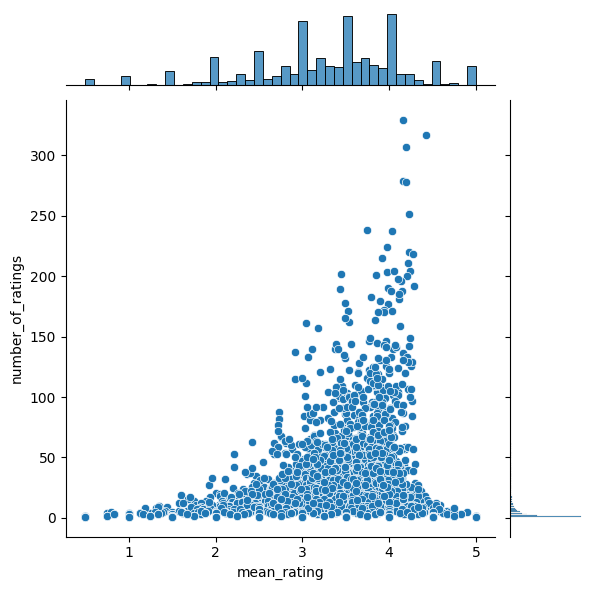

In [77]:
# Model construction
avg_ratings = df_total.groupby('movieId').agg(mean_rating = ('rating', 'mean'),
                                                number_of_ratings = ('rating', 'count')).reset_index()
# Check popular movies
avg_ratings.sort_values(by='number_of_ratings', ascending=False)

# Visulization
sns.jointplot(x='mean_rating', y='number_of_ratings', data=avg_ratings)

# Create user-item matrix
matrix = df_total.pivot_table(index='userId', columns='title', values='rating')
matrix.head()
# matrix_1 = matrix.fillna(0)

# Normalize user-item matrix
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()
matrix_norm = matrix_norm.fillna(0)

matrix_norm

In [78]:
# User similarity matrix using cosine similarity
user_similarity_cosine = cosine_similarity(matrix_norm)
similarity_matrix_df = pd.DataFrame(user_similarity_cosine, index=matrix_norm.index, columns=matrix_norm.index)
similarity_matrix_df

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.001265,0.000553,0.048419,0.021847,-0.045497,-0.006200,0.047013,0.019510,-0.009316,...,0.018871,-0.017172,-0.015221,-0.037059,-0.029121,0.012016,0.055261,0.075224,-0.025713,0.010932
2,0.001265,1.000000,0.000000,-0.017164,0.021796,-0.021051,-0.011114,-0.048085,0.000000,0.003059,...,-0.051118,-0.031581,-0.001688,0.000000,0.000000,0.006226,-0.020504,-0.006001,-0.060091,0.024999
3,0.000553,0.000000,1.000000,-0.011260,-0.031539,0.004800,0.000000,-0.032471,0.000000,0.000000,...,-0.005381,-0.016117,0.017749,0.000000,-0.001431,-0.037289,-0.007789,-0.013001,0.000000,0.019550
4,0.048419,-0.017164,-0.011260,1.000000,-0.029620,0.013956,0.058091,0.002065,-0.005874,0.054495,...,-0.038478,0.063122,0.027640,-0.013782,0.040037,0.020590,0.014628,-0.037569,-0.017884,-0.000995
5,0.021847,0.021796,-0.031539,-0.029620,1.000000,0.009111,0.010117,-0.012284,0.000000,-0.035152,...,0.016422,0.012427,0.027076,0.012461,-0.036272,0.026319,0.031896,-0.001751,0.093829,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,0.006226,-0.037289,0.020590,0.026319,-0.009137,0.028326,0.022277,0.031633,-0.043352,...,0.055391,0.016384,0.098011,0.061078,0.019678,1.000000,0.017927,0.056676,0.038422,0.075464
607,0.055261,-0.020504,-0.007789,0.014628,0.031896,0.045501,0.030981,0.048822,-0.012161,-0.018699,...,0.050277,0.038197,0.049317,0.002355,-0.029381,0.017927,1.000000,0.044514,0.019049,0.021860
608,0.075224,-0.006001,-0.013001,-0.037569,-0.001751,0.021727,0.028414,0.071759,0.032783,-0.055887,...,0.071169,0.051388,0.012801,0.006319,-0.007978,0.056676,0.044514,1.000000,0.050714,0.054454


In [79]:
#function to calculate ratings
def predict_rating(movieId, userId):
    if movieId in matrix_norm:
        cosine_scores = similarity_matrix_df[userId] #similarity of id_user with every other user
        ratings_scores = matrix_norm[movieId]      #ratings of every other user for the movie id_movie
        #won't consider users who havent rated id_movie so drop similarity scores and ratings corresponsing to np.nan
        index_not_rated = ratings_scores[ratings_scores.isnull()].index
        ratings_scores = ratings_scores.dropna()
        cosine_scores = cosine_scores.drop(index_not_rated)
        #calculating rating by weighted mean of ratings and cosine scores of the users who have rated the movie
        ratings_movie = np.dot(ratings_scores, cosine_scores)/cosine_scores.sum()
    else:
        return 2.5
    return ratings_movie

#evaluates on test set
def score_on_test_set():
    user_movie_pairs = zip(df_test['movieId'], df_test['userId'])
    predicted_ratings = np.array([predict_rating(movieId, userId) for (movieId, userId) in user_movie_pairs])
    true_ratings = np.array(df_test['rating'])
    score = np.sqrt(mean_squared_error(true_ratings, predicted_ratings))
    return score
test_set_score = score_on_test_set()
print(f"RMSE = {test_set_score:.4f}")

RMSE = 1.3345


# SVD MODEl

In [80]:
# SVD
from surprise import Dataset, Reader, SVD, accuracy
# rating reader
reader = Reader(rating_scale=(0,5))
# Load Train dataset
ds_user_item=Dataset.load_from_df(ratings_train[["userId","movieId","rating"]], reader)
# Load Valid dataset (must be changeable)
ds_user_item_valid=Dataset.load_from_df(ratings_valid[["userId","movieId","rating"]], reader)

trainset = ds_user_item.build_full_trainset()
testset= ds_user_item_valid.build_full_trainset()
svd=SVD(n_factors=100, n_epochs=100, lr_all=0.005, reg_all=0.02)
svd.fit(trainset)
pred=svd.test(testset.build_testset())
uid = [p.uid for p in pred]
iid = [p.iid for p in pred]
est = [p.est for p in pred]
pred_df = pd.DataFrame({'userId': uid, 'movieId': iid, 'rating': est})
pred_df
#for pre in pred:
#    print(pre.est)

,userId,movieId,rating
0,4,45,3.560677
1,4,52,2.682808
2,4,58,4.009782
3,4,222,3.218116
4,4,247,4.079633
...,...,...,...
2349,561,139385,3.365218
2350,561,146656,3.377012
2351,561,149406,2.987839
2352,561,160438,2.708476


In [81]:
def predict_rating_SVD(df):
    # Input: 
	# 	df = a dataframe with two columns: userId, movieId
	# Output:
	#   a dataframe with three columns: userId, movieId, rating
    new_df=pd.merge(df,pred_df,on=["userId","movieId"],how="left")
    return new_df  #df.join(avg_rating, on='movieId')

In [82]:
# Prepare df for prediction
r = ratings_valid[['userId', 'movieId']]

# Predict ratings
ratings_pred = predict_rating_SVD(r)
ratings_pred

r_true = ratings_valid['rating'].to_numpy()
r_pred = ratings_pred['rating'].to_numpy()

rmse = mean_squared_error(r_true, r_pred, squared=False)
print(f"RMSE = {rmse:.4f}")

RMSE = 0.8525


###KNN model ###

In [83]:
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
# split data into train and test sets
train_data, test_data = train_test_split(matrix_norm, test_size=0.2, random_state=42)

# Fit KNN model on train data
k = 10
model = NearestNeighbors(n_neighbors=k, metric='cosine')
model.fit(train_data)


# Generate predictions on test data
test_indices = model.kneighbors(test_data, return_distance=False)
test_predictions = np.zeros(test_data.shape)
for i in range(len(test_data)):
    user = test_data.iloc[i,:]
    neighbor_indices = test_indices[i,:]
    neighbor_ratings = train_data.iloc[neighbor_indices,:]
    test_predictions[i,:] = neighbor_ratings.mean(axis=0)
    
# Calculate RMSE
test_targets = test_data.to_numpy()
rmse = np.sqrt(mean_squared_error(test_targets[test_targets.nonzero()], test_predictions[test_targets.nonzero()]))

print('RMSE:', rmse)



RMSE: 0.8191438362419401
